## 라이브러리 불러오기

In [151]:
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.15.0-dev20231005


## 데이터세트 불러오기

In [152]:
import pathlib
workspace_dir = '/home/shin/Graduation_Project/tensorflow_custom/tflite_model'
data_dir = '/home/shin/Graduation_Project/data/12_07_05/노지 작물 해충 진단 이미지/distributed_final/cropped/train'
data_dir = pathlib.Path(data_dir)
print(data_dir)

DIR = 'mobilenet_v3'

batch_size = 32
img_height = 80
img_width = 80

image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.JPG'))) +len(list(data_dir.glob('*/*.JPEG'))) + len(list(data_dir.glob('*/*.jpeg')))  
print(image_count)

/home/shin/Graduation_Project/data/12_07_05/노지 작물 해충 진단 이미지/distributed_final/cropped/train
3884


### 무잎벌 이미지 확인

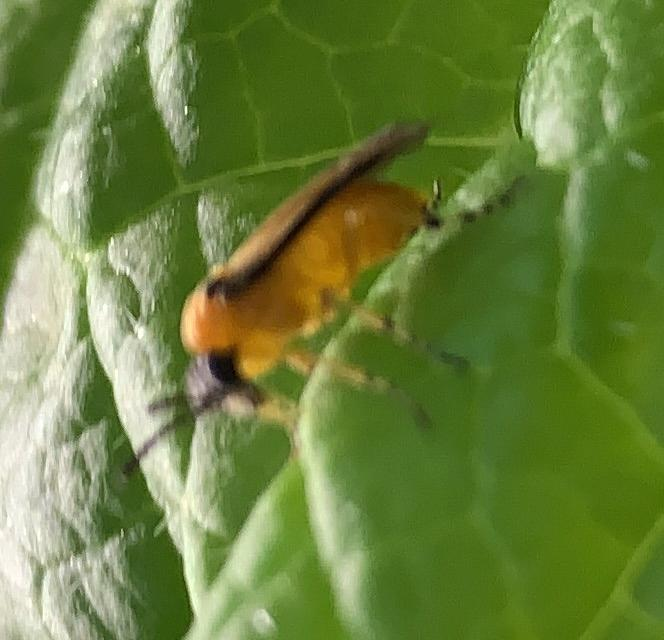

In [153]:

bee = list(data_dir.glob('bee/*.jpg')) + list(data_dir.glob('bee/*.JPG')) + list(data_dir.glob('bee/*.JPEG')) + list(data_dir.glob('bee/*.jpeg'))
PIL.Image.open(str(bee[0]))



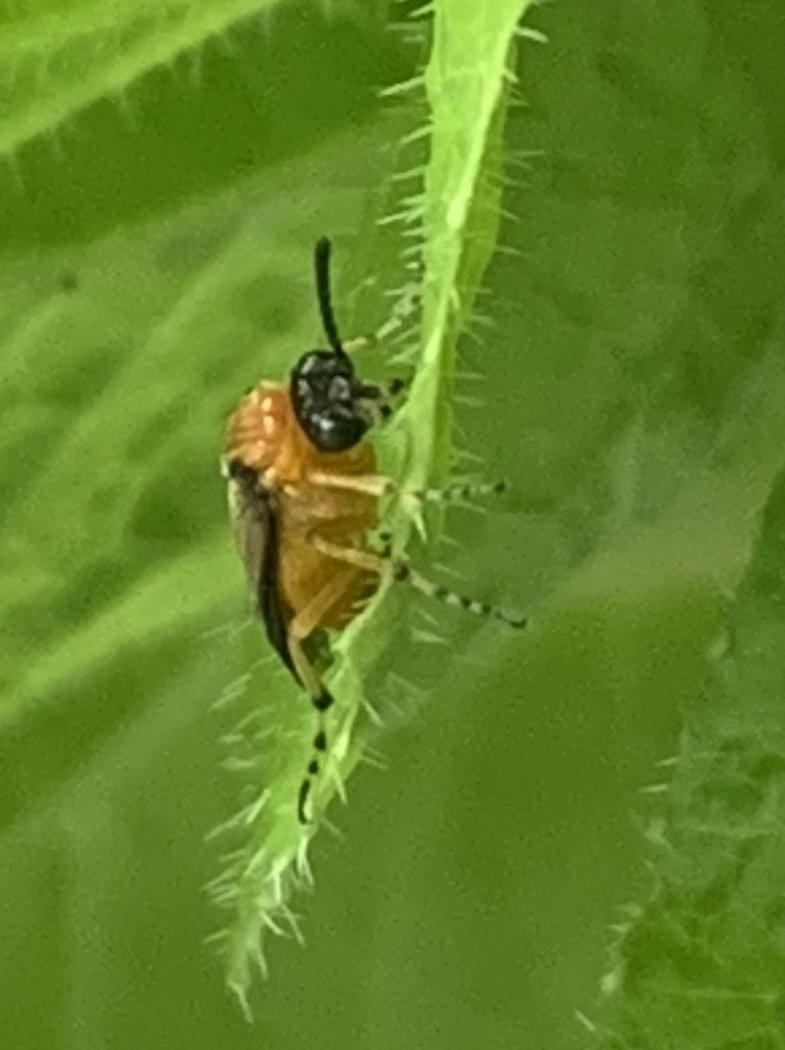

In [154]:
PIL.Image.open(str(bee[1]))

### 나방 이미지 확인

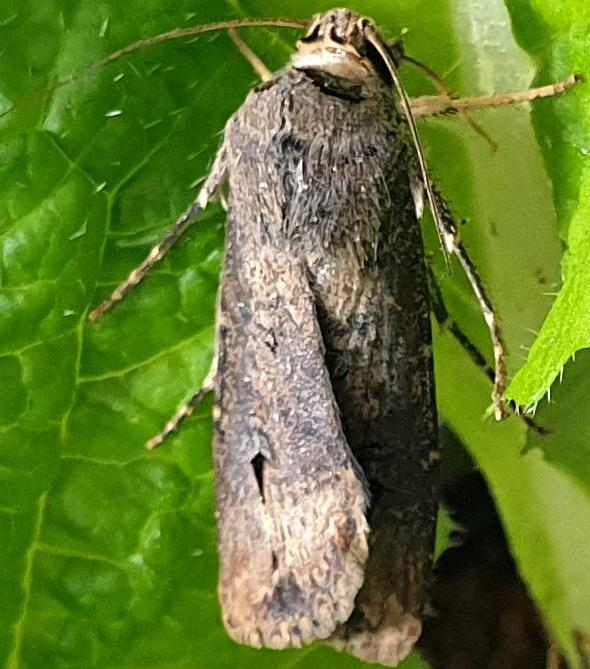

In [155]:
moth = list(data_dir.glob('moth/*.jpg')) + list(data_dir.glob('moth/*.JPG'))
PIL.Image.open(str(moth[0]))

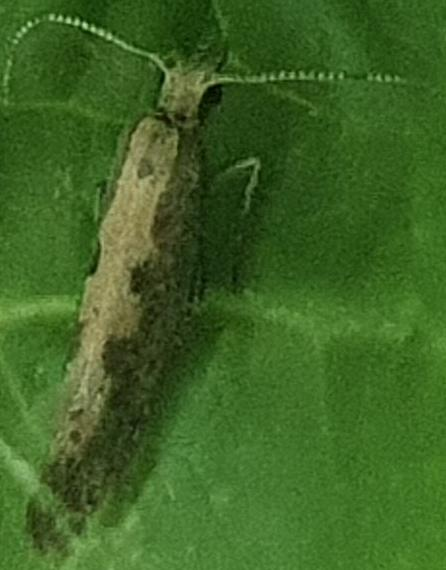

In [156]:
PIL.Image.open(str(moth[1]))

## 모델 생성

### 데이터세트 만들기

In [157]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3884 files belonging to 4 classes.
Using 3108 files for training.
Using 776 files for validation.
['bee', 'butterfly', 'moth', 'stink']


### 데이터 시각화하기

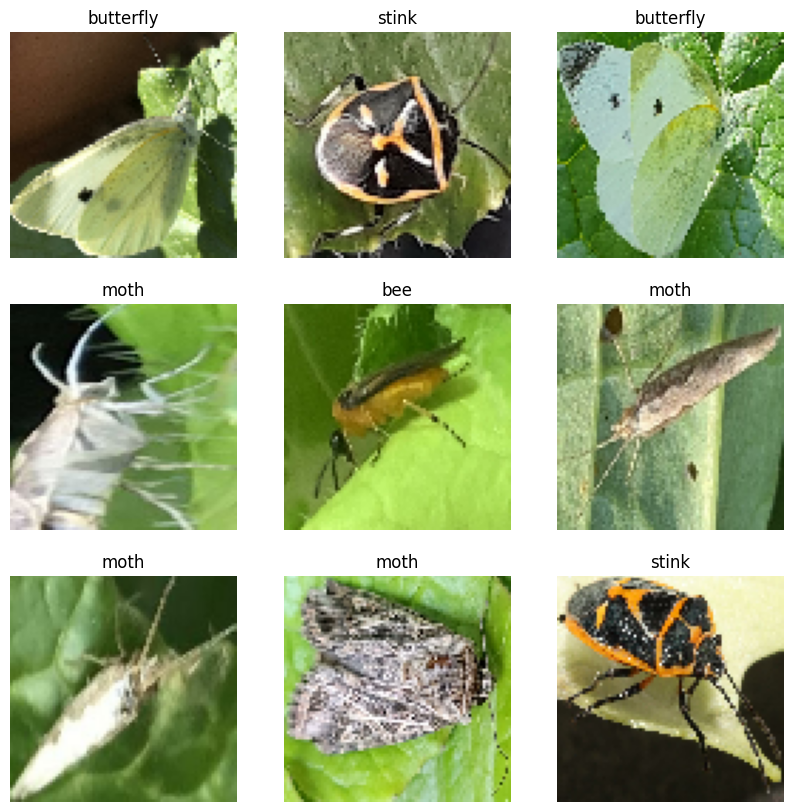

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [159]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 80, 80, 3)
(32,)


### 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

In [160]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 증강

In [161]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강 예제를 시각화합니다.

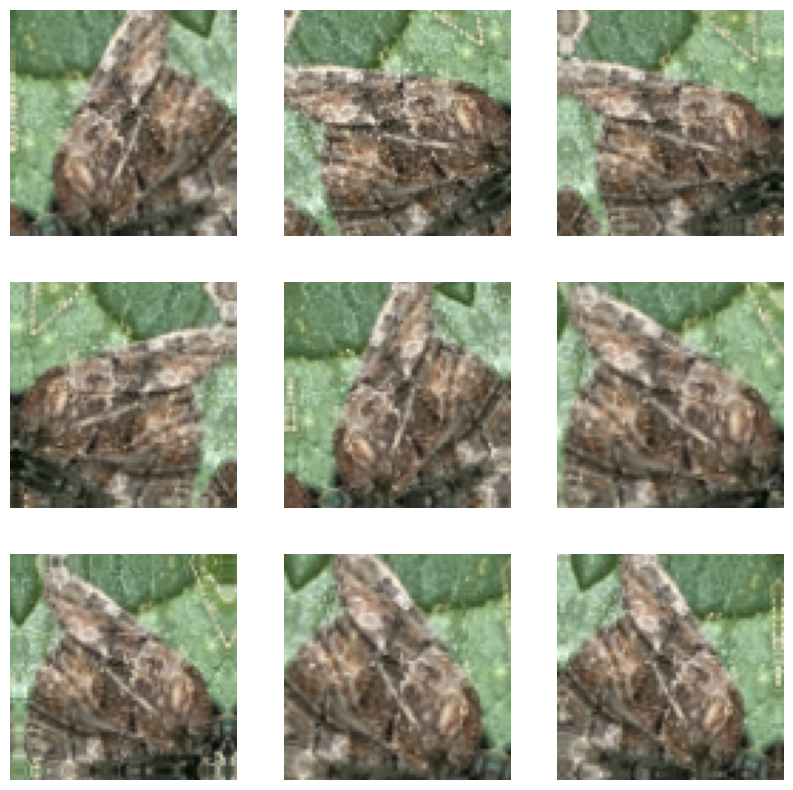

In [162]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 모델 생성 및 요약

In [208]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(rate=0.8),
  layers.Dense(num_classes, activation="softmax")
])

model.summary()



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 80, 80, 3)         0         
                                                                 
 conv2d_70 (Conv2D)          (None, 80, 80, 4)         112       
                                                                 
 conv2d_71 (Conv2D)          (None, 80, 80, 4)         148       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 40, 40, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 40, 40, 8)         296       
                                                                 
 conv2d_73 (Conv2D)          (None, 40, 40, 8)         584       
                                                     

### 모델 컴파일

In [209]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 학습

In [210]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/25


/home/shin/.conda/envs/tf11/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


98/98 [==============================] - 3s 17ms/step - loss: 1.2538 - accuracy: 0.3774 - val_loss: 0.9592 - val_accuracy: 0.5902
Epoch 2/25
98/98 [==============================] - 2s 16ms/step - loss: 0.9196 - accuracy: 0.6030 - val_loss: 0.7049 - val_accuracy: 0.7384
Epoch 3/25
98/98 [==============================] - 2s 15ms/step - loss: 0.7369 - accuracy: 0.6937 - val_loss: 0.5667 - val_accuracy: 0.7680
Epoch 4/25
98/98 [==============================] - 2s 15ms/step - loss: 0.7007 - accuracy: 0.7159 - val_loss: 0.5374 - val_accuracy: 0.7771
Epoch 5/25
98/98 [==============================] - 2s 16ms/step - loss: 0.5870 - accuracy: 0.7654 - val_loss: 0.5279 - val_accuracy: 0.7745
Epoch 6/25
98/98 [==============================] - 2s 15ms/step - loss: 0.5501 - accuracy: 0.7835 - val_loss: 0.4526 - val_accuracy: 0.8131
Epoch 7/25
98/98 [==============================] - 2s 15ms/step - loss: 0.5074 - accuracy: 0.7989 - val_loss: 0.4822 - val_accuracy: 0.8003
Epoch 8/25
98/98 [======

In [211]:
model.evaluate(
    train_ds
)

98/98 [==============================] - 1s 11ms/step - loss: 0.1084 - accuracy: 0.9598


[0.10840202122926712, 0.9597812294960022]

### 모델 저장

In [212]:
export_dir = f'{workspace_dir}/saved_model/{DIR}'
tf.saved_model.save(model, export_dir)

# Keras 모델로 변환하기
keras_model = tf.keras.models.Sequential(model.layers)

# Keras 모델 저장하기
keras_model.save(f'{workspace_dir}/saved_model/{DIR}/model.h5')

INFO:tensorflow:Assets written to: /home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/mobilenet_v3/assets


INFO:tensorflow:Assets written to: /home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/mobilenet_v3/assets


/home/shin/.conda/envs/tf11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## TensorFlow Lite

### TensorFlow Lite 변환

In [213]:
# Convert the model.
tflite_model_path = f'{workspace_dir}/saved_model/{DIR}/saved_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3ofns520/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ofns520/assets
2023-10-09 22:39:42.818280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-09 22:39:42.818304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-09 22:39:42.818429: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3ofns520
2023-10-09 22:39:42.819659: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-09 22:39:42.819671: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3ofns520
2023-10-09 22:39:42.822934: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-09 22:39:42.879304: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3ofns520
2023-10-09 22:39:42.894606: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

### TensorFlow Lite 모델 PC에서 실행하여 확인하기

In [214]:
TF_MODEL_FILE_PATH = tflite_model_path # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

## 양자화

### representative_data_gen() 메서드 선언

In [225]:
numpy_arrays = []

for batch in train_ds:
    images, labels = batch
    for image in images:
      image_numpy = image.numpy()  # 이미지 배치를 NumPy 배열로 변환

      numpy_arrays.append(image_numpy)

print(len(numpy_arrays))
print(len(numpy_arrays[0]))
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(numpy_arrays).batch(1).take(100):
    yield [input_value]


3108
80


### 양자화 수행

In [226]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvnt41xhx/assets


INFO:tensorflow:Assets written to: /tmp/tmpvnt41xhx/assets
/home/shin/.conda/envs/tf11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-10-09 23:21:01.950116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-09 23:21:01.950145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-09 23:21:01.950280: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvnt41xhx
2023-10-09 23:21:01.952052: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-09 23:21:01.952069: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvnt41xhx
2023-10-09 23:21:01.956542: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-09 23:

### 양자화 모델 저장

In [228]:
tflite_model_quant_path = f'{workspace_dir}/saved_model/{DIR}/saved_model_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print(f"TensorFlow Lite 모델이 '{tflite_model_quant_path}'에 저장되었습니다.")

TensorFlow Lite 모델이 '/home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/mobilenet_v3/saved_model_quant.tflite'에 저장되었습니다.
